In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deberta-v3-large/deberta-v3-large/spm.model
/kaggle/input/deberta-v3-large/deberta-v3-large/config.json
/kaggle/input/deberta-v3-large/deberta-v3-large/README.md
/kaggle/input/deberta-v3-large/deberta-v3-large/tf_model.h5
/kaggle/input/deberta-v3-large/deberta-v3-large/tokenizer_config.json
/kaggle/input/deberta-v3-large/deberta-v3-large/pytorch_model.bin
/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv
/kaggle/input/feedback-prize-english-language-learning/train.csv
/kaggle/input/feedback-prize-english-language-learning/test.csv
/kaggle/input/iterativestratification/.travis.yml
/kaggle/input/iterativestratification/setup.cfg
/kaggle/input/iterativestratification/LICENSE
/kaggle/input/iterativestratification/.gitignore
/kaggle/input/iterativestratification/README.md
/kaggle/input/iterativestratification/setup.py
/kaggle/input/iterativestratification/tests/test_ml_stratifiers.py
/kaggle/input/iterativestratification/tests/__init__.py
/kaggle/inp

# Load libraries

In [3]:
import os, gc
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers

import transformers
from transformers import TFAutoModel, AutoTokenizer, AutoConfig
import sys 
sys.path.append('../input/iterativestratification')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


# Import Dataset

In [4]:
train = pd.read_csv('../input/feedback-prize-english-language-learning/train.csv')
test = pd.read_csv('../input/feedback-prize-english-language-learning/test.csv')
sample_submission = pd.read_csv('../input/feedback-prize-english-language-learning/sample_submission.csv')

train.head(), test.head(), sample_submission.head()

(        text_id                                          full_text  cohesion  \
 0  0016926B079C  I think that students would benefit from learn...       3.5   
 1  0022683E9EA5  When a problem is a change you have to let it ...       2.5   
 2  00299B378633  Dear, Principal\n\nIf u change the school poli...       3.0   
 3  003885A45F42  The best time in life is when you become yours...       4.5   
 4  0049B1DF5CCC  Small act of kindness can impact in other peop...       2.5   
 
    syntax  vocabulary  phraseology  grammar  conventions  
 0     3.5         3.0          3.0      4.0          3.0  
 1     2.5         3.0          2.0      2.0          2.5  
 2     3.5         3.0          3.0      3.0          2.5  
 3     4.5         4.5          4.5      4.0          5.0  
 4     3.0         3.0          3.0      2.5          2.5  ,
         text_id                                          full_text
 0  0000C359D63E  when a person has no experience on a job their...
 1  000BAD50D02

# Create Cross-Validation split

In [5]:
# create 5 folds for cross validation
N_FOLD = 5
TARGET_COLS = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

In [6]:
# apply kfold on dataset
folds = MultilabelStratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=42)

for n, (train_index, val_index) in enumerate(folds.split(train, train[TARGET_COLS])):
    train.loc[val_index, 'fold'] = int(n)

train['fold'] = train['fold'].astype(int)
train['fold'].value_counts()

1    783
0    782
4    782
3    782
2    782
Name: fold, dtype: int64

In [7]:
# check train dataset after adding fold column
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,fold
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,1
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,0
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,4
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,3
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,1


# Model configuration

In [8]:
# standard config
MAX_LENGTH = 512
BATCH_SIZE = 8

MODEL = "../input/roberta-base/"

In [10]:
# load our models

model = TFAutoModel.from_pretrained(MODEL)
tokenizer = AutoTokenizer.from_pretrained(MODEL)

CFG = transformers.AutoConfig.from_pretrained(MODEL)
CFG.hidden_dropout_prob = 0.
CFG.attention_probs_dropout_prob = 0.

2022-10-30 15:25:59.439790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 15:25:59.440866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 15:25:59.441580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 15:25:59.442491: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Data Processing Functions

In [11]:
def CreateEmbeddings(texts, tokenizer=tokenizer):
    
    """Generate embeddings and attention_masks from text """

    input_ids = []
    attention_mask = []
    
    for text in texts.to_list():
        token = tokenizer(text, 
                          add_special_tokens=True,
                          max_length=MAX_LENGTH,
                          return_attention_mask=True, 
                          return_tensors='np',
                          truncation=True,
                          padding='max_length')
        input_ids.append(token['input_ids'][0])
        attention_mask.append(token['attention_mask'][0])
    
    return np.array(input_ids), np.array(attention_mask) 

In [18]:
def GetDataset(dataframe):
    
    """Create dataset object from dataframe"""
    
    inputs = CreateEmbeddings(dataframe['full_text'])
    targets = np.array(dataframe[TARGET_COLS])
    
    return inputs, targets

# MeanPooling Layer

Instead of using '[CLS]' token, MeanPool layer averaging roberta's last hidden states along the sequence axis with masking out padding tokens.

In [19]:
class MeanPooling(tf.keras.layers.Layer):
    
    def call(self, inputs, mask=None):
        
        """Generate sentence embeddings for each text by applying meanpooling """
        
        total_mask = tf.expand_dims(tf.cast(mask, "float32"), -1)
        embedding_sum = tf.reduce_sum(inputs * total_mask, axis=1)
        mask_sum = tf.reduce_sum(total_mask, axis=1)
        mask_sum = tf.math.maximum(mask_sum, tf.constant([1e-9]))
        
        return embedding_sum / mask_sum

# Build the Model

In [20]:
def MainModel():

    """ Create the fully connected Neural Network model from the output embeddings"""
    
    input_ids = tf.keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name="input_ids")
    attention_masks = tf.keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name="attention_masks")
   
    model = transformers.TFAutoModel.from_pretrained(MODEL, config=CFG)
    model_output = model.roberta(input_ids, attention_mask=attention_masks)
    
    x = model_output.last_hidden_state
    x = MeanPooling()(x, mask=attention_masks)
    x = layers.Dense(6, activation='sigmoid')(x)
    
    output = layers.Rescaling(scale=4.0, offset=1.0)(x)
    model = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=output)
    
    return model

In [21]:
# review model structure
tf.keras.backend.clear_session()
model = MainModel()
model.summary()

Some layers from the model checkpoint at ../input/roberta-base/ were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at ../input/roberta-base/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 512)]        0                                            
__________________________________________________________________________________________________
roberta (TFRobertaMainLayer)    TFBaseModelOutputWit 124645632   input_ids[0][0]                  
                                                                 attention_masks[0][0]            
__________________________________________________________________________________________________
mean_pooling (MeanPooling)      (None, 768)          0           roberta[0][0]                

# 5 Folds training loop

In [24]:
# create 5 training loop and store results of best folds using callbacks

valid_rmses = []

for fold in range(N_FOLD):
    print(f'\n=== FOLD {fold} ===')
    
    # Generate dataset
    train_df = train[train['fold'] != fold].reset_index(drop=True)
    valid_df = train[train['fold'] == fold].reset_index(drop=True)
    train_dataset = GetDataset(train_df)
    valid_dataset = GetDataset(valid_df)
    
    print('=== Data loaded ===')
    
    #Create model
    tf.keras.backend.clear_session()
    
    model = MainModel()
    
    # Compile model with layer-wise learning rate decay
    LR_SCH_DECAY_STEPS = 2 * len(train_df) // BATCH_SIZE
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                                initial_learning_rate=1e-5, 
                                decay_steps=LR_SCH_DECAY_STEPS, 
                                decay_rate=0.3)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer,
                 loss='mean_squared_error',
                 metrics=[tf.keras.metrics.RootMeanSquaredError()],
                 )

    
    #Training model
    print('=== Start training ===')
    callbacks = [
                tf.keras.callbacks.ModelCheckpoint(f"best_model_fold{fold}.h5",
                                                   monitor="val_loss",
                                                   mode="min",
                                                   save_best_only=True,
                                                   verbose=1,
                                                   save_weights_only=True,),
                tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                 min_delta=1e-5, 
                                                 patience=3, 
                                                 verbose=1,
                                                 mode='min',)
                ]
    
    history = model.fit(x=train_dataset[0],
                        y=train_dataset[1],
                        validation_data=valid_dataset, 
                        epochs=10,
                        shuffle=True,
                        batch_size=BATCH_SIZE,
                        callbacks=callbacks
                       )
    
    valid_rmses.append(np.min(history.history['val_root_mean_squared_error']))
    
    print('=== Training finished ===')
    
    del train_dataset, valid_dataset, train_df, valid_df
    
    gc.collect()


=== FOLD 0 ===
=== Data loaded ===


Some layers from the model checkpoint at ../input/roberta-base/ were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at ../input/roberta-base/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


=== Start training ===
Epoch 1/10
392/392 [==============================] - 246s 593ms/step - loss: 0.2652 - root_mean_squared_error: 0.5150 - val_loss: 0.2166 - val_root_mean_squared_error: 0.4654

Epoch 00001: val_loss improved from inf to 0.21662, saving model to best_model_fold0.h5
Epoch 2/10
392/392 [==============================] - 229s 585ms/step - loss: 0.2039 - root_mean_squared_error: 0.4515 - val_loss: 0.2096 - val_root_mean_squared_error: 0.4578

Epoch 00002: val_loss improved from 0.21662 to 0.20958, saving model to best_model_fold0.h5
Epoch 3/10
392/392 [==============================] - 229s 585ms/step - loss: 0.1856 - root_mean_squared_error: 0.4308 - val_loss: 0.2190 - val_root_mean_squared_error: 0.4679

Epoch 00003: val_loss did not improve from 0.20958
Epoch 4/10
392/392 [==============================] - 229s 585ms/step - loss: 0.1731 - root_mean_squared_error: 0.4161 - val_loss: 0.2094 - val_root_mean_squared_error: 0.4576

Epoch 00004: val_loss improved from 0.

Some layers from the model checkpoint at ../input/roberta-base/ were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at ../input/roberta-base/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


=== Start training ===
Epoch 1/10
391/391 [==============================] - 230s 566ms/step - loss: 0.2594 - root_mean_squared_error: 0.5093 - val_loss: 0.2178 - val_root_mean_squared_error: 0.4667

Epoch 00001: val_loss improved from inf to 0.21777, saving model to best_model_fold1.h5
Epoch 2/10
391/391 [==============================] - 219s 560ms/step - loss: 0.1981 - root_mean_squared_error: 0.4451 - val_loss: 0.2184 - val_root_mean_squared_error: 0.4673

Epoch 00002: val_loss did not improve from 0.21777
Epoch 3/10
391/391 [==============================] - 219s 560ms/step - loss: 0.1769 - root_mean_squared_error: 0.4206 - val_loss: 0.2170 - val_root_mean_squared_error: 0.4658

Epoch 00003: val_loss improved from 0.21777 to 0.21697, saving model to best_model_fold1.h5
Epoch 4/10
391/391 [==============================] - 219s 560ms/step - loss: 0.1633 - root_mean_squared_error: 0.4041 - val_loss: 0.2152 - val_root_mean_squared_error: 0.4638

Epoch 00004: val_loss improved from 0.

Some layers from the model checkpoint at ../input/roberta-base/ were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at ../input/roberta-base/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


=== Start training ===
Epoch 1/10
392/392 [==============================] - 245s 591ms/step - loss: 0.2456 - root_mean_squared_error: 0.4956 - val_loss: 0.2241 - val_root_mean_squared_error: 0.4734

Epoch 00001: val_loss improved from inf to 0.22414, saving model to best_model_fold2.h5
Epoch 2/10
392/392 [==============================] - 229s 584ms/step - loss: 0.1967 - root_mean_squared_error: 0.4435 - val_loss: 0.2197 - val_root_mean_squared_error: 0.4687

Epoch 00002: val_loss improved from 0.22414 to 0.21967, saving model to best_model_fold2.h5
Epoch 3/10
392/392 [==============================] - 229s 585ms/step - loss: 0.1809 - root_mean_squared_error: 0.4254 - val_loss: 0.2169 - val_root_mean_squared_error: 0.4657

Epoch 00003: val_loss improved from 0.21967 to 0.21690, saving model to best_model_fold2.h5
Epoch 4/10
392/392 [==============================] - 229s 585ms/step - loss: 0.1696 - root_mean_squared_error: 0.4118 - val_loss: 0.2180 - val_root_mean_squared_error: 0.466

Some layers from the model checkpoint at ../input/roberta-base/ were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at ../input/roberta-base/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


=== Start training ===
Epoch 1/10
392/392 [==============================] - 245s 591ms/step - loss: 0.2604 - root_mean_squared_error: 0.5103 - val_loss: 0.2227 - val_root_mean_squared_error: 0.4719

Epoch 00001: val_loss improved from inf to 0.22268, saving model to best_model_fold3.h5
Epoch 2/10
392/392 [==============================] - 229s 584ms/step - loss: 0.2017 - root_mean_squared_error: 0.4491 - val_loss: 0.2314 - val_root_mean_squared_error: 0.4810

Epoch 00002: val_loss did not improve from 0.22268
Epoch 3/10
392/392 [==============================] - 229s 584ms/step - loss: 0.1841 - root_mean_squared_error: 0.4291 - val_loss: 0.2125 - val_root_mean_squared_error: 0.4610

Epoch 00003: val_loss improved from 0.22268 to 0.21254, saving model to best_model_fold3.h5
Epoch 4/10
392/392 [==============================] - 229s 584ms/step - loss: 0.1728 - root_mean_squared_error: 0.4157 - val_loss: 0.2133 - val_root_mean_squared_error: 0.4618

Epoch 00004: val_loss did not improve 

Some layers from the model checkpoint at ../input/roberta-base/ were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at ../input/roberta-base/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


=== Start training ===
Epoch 1/10
392/392 [==============================] - 245s 591ms/step - loss: 0.2627 - root_mean_squared_error: 0.5125 - val_loss: 0.2221 - val_root_mean_squared_error: 0.4712

Epoch 00001: val_loss improved from inf to 0.22206, saving model to best_model_fold4.h5
Epoch 2/10
392/392 [==============================] - 229s 585ms/step - loss: 0.1990 - root_mean_squared_error: 0.4461 - val_loss: 0.2146 - val_root_mean_squared_error: 0.4632

Epoch 00002: val_loss improved from 0.22206 to 0.21456, saving model to best_model_fold4.h5
Epoch 3/10
392/392 [==============================] - 229s 585ms/step - loss: 0.1786 - root_mean_squared_error: 0.4227 - val_loss: 0.2105 - val_root_mean_squared_error: 0.4588

Epoch 00003: val_loss improved from 0.21456 to 0.21049, saving model to best_model_fold4.h5
Epoch 4/10
392/392 [==============================] - 229s 584ms/step - loss: 0.1664 - root_mean_squared_error: 0.4079 - val_loss: 0.2135 - val_root_mean_squared_error: 0.462

In [29]:
# print average score by folds
print(f'{len(valid_rmses)} Folds validation RMSE:\n{valid_rmses}')
print(f'Local CV Average score: {np.mean(valid_rmses)}')

5 Folds validation RMSE:
[0.45707303285598755, 0.4638441503047943, 0.46565210819244385, 0.4610193371772766, 0.4584513008594513]
Local CV Average score: 0.4612079858779907


In [38]:
# review history
print(history.history)

{'loss': [0.26265501976013184, 0.19903627038002014, 0.17864340543746948, 0.16635850071907043, 0.15772423148155212, 0.15279991924762726, 0.15021324157714844, 0.14871016144752502], 'root_mean_squared_error': [0.5124987363815308, 0.44613468647003174, 0.4226624667644501, 0.4078707695007324, 0.39714503288269043, 0.3908964693546295, 0.3875734210014343, 0.3856296241283417], 'val_loss': [0.22205579280853271, 0.21455681324005127, 0.21048974990844727, 0.21347959339618683, 0.21017764508724213, 0.21203933656215668, 0.21148182451725006, 0.21188902854919434], 'val_root_mean_squared_error': [0.47122782468795776, 0.4632028043270111, 0.458791583776474, 0.4620385468006134, 0.4584513008594513, 0.4604773223400116, 0.4598715305328369, 0.4603140950202942]}


### Accessing Loss progress

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


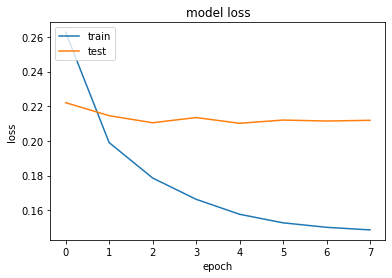

In [39]:
# put the progress of loss into chart
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Create prediction

In [26]:
test.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [31]:
# create dataset for test 
test_dataset = CreateEmbeddings(test['full_text'])

In [33]:
# create predictions
predictions = []

# Loading weights from best performance folds
for fold in range(5):
    tf.keras.backend.clear_session()
    model = MainModel()
    model.load_weights(f'best_model_fold{fold}.h5')
    print(f'\nFold {fold} predictions')
    prediction = model.predict(test_dataset, batch_size=8)
    predictions.append(prediction)
    gc.collect()

Some layers from the model checkpoint at ../input/roberta-base/ were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at ../input/roberta-base/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.



Fold 0 predictions


Some layers from the model checkpoint at ../input/roberta-base/ were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at ../input/roberta-base/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.



Fold 1 predictions


Some layers from the model checkpoint at ../input/roberta-base/ were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at ../input/roberta-base/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.



Fold 2 predictions


Some layers from the model checkpoint at ../input/roberta-base/ were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at ../input/roberta-base/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.



Fold 3 predictions


Some layers from the model checkpoint at ../input/roberta-base/ were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at ../input/roberta-base/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.



Fold 4 predictions


In [35]:
# submit the predictions to Kaggle

predictions = np.mean(predictions, axis=0)

submission = pd.concat([test[['text_id']], pd.DataFrame(predictions, columns=TARGET_COLS)], axis=1)

submission.to_csv('submission.csv', index=False)

submission.head()

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,2.863481,2.774186,3.036548,2.929232,2.681797,2.575963
1,000BAD50D026,2.764522,2.541825,2.760355,2.452696,2.234032,2.722997
2,00367BB2546B,3.560313,3.387542,3.597499,3.554564,3.367234,3.327986
